In [7]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist

from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation

import numpy as np
import random

import matplotlib.pyplot as plt

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [9]:
y_train.shape

(60000,)

In [10]:
new_test = np.zeros((10000,28,28))
new_test[:5000] = x_train[:5000]
new_test[5000:] = x_test[:5000]

new_test_y = np.zeros(10000)
new_test_y[:5000] = y_train[:5000]
new_test_y[5000:] = y_test[:5000]

np.save("mnist_test_x.npy", new_test)
np.save("mnist_test_y.npy", new_test_y)
np.save("mnist_train_x.npy", x_train)
np.save("mnist_train_y.npy", y_train)


In [ ]:

def loader():
  x_test = np.load('mnist_test_x.npy')
  x_train = np.load('mnist_train_x.npy')
  y_test = np.load('mnist_test_y.npy')
  y_train = np.load('mnist_train_y.npy')
  return x_train, y_train, x_test, y_test 

x_train, y_train, x_test, y_test = loader()


In [11]:
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

In [12]:
img_rows, img_cols, channels = 28, 28, 1
num_classes = 10

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

Data shapes (10000, 28, 28, 1) (10000, 10) (60000, 28, 28, 1) (60000, 10)


In [13]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu', input_shape=(img_rows, img_cols, channels)))
model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)               

In [15]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [16]:
model.fit(x_train, y_train,
          batch_size=32,
          epochs=19,
          validation_data=(x_test, y_test))

2021-10-15 19:53:22.003919: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-15 19:53:22.006234: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-10-15 19:53:22.194744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/19
1872/1875 [============================>.] - ETA: 0s - loss: 0.0197 - accuracy: 0.8626

2021-10-15 19:53:36.146121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 15s 6ms/step - loss: 0.0197 - accuracy: 0.8627 - val_loss: 0.0068 - val_accuracy: 0.9553
Epoch 2/19
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0092 - accuracy: 0.9396 - val_loss: 0.0050 - val_accuracy: 0.9659
Epoch 3/19
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0076 - accuracy: 0.9500 - val_loss: 0.0043 - val_accuracy: 0.9713
Epoch 4/19
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0063 - accuracy: 0.9594 - val_loss: 0.0037 - val_accuracy: 0.9767
Epoch 5/19
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0058 - accuracy: 0.9629 - val_loss: 0.0033 - val_accuracy: 0.9786
Epoch 6/19
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0053 - accuracy: 0.9662 - val_loss: 0.0035 - val_accuracy: 0.9776
Epoch 7/19
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0050 - accuracy: 0.9676 - val_loss: 0.0038 - val_accuracy: 0.9

In [17]:
model.evaluate(x=x_test, y=y_test, verbose=0)

[0.002612134674564004, 0.9841000437736511]

In [18]:
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

In [19]:
image = x_train[0]
image_label = y_train[0]
image_label

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [20]:
perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()

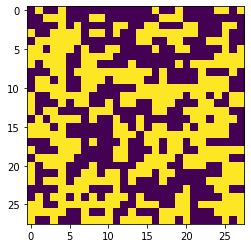

In [21]:
if channels == 1:
    plt.imshow(perturbations.reshape((img_rows, img_cols)))
else:
    plt.imshow(perturbations.reshape((img_rows, img_cols, channels)))
plt.show()

In [22]:
adversarial = image + perturbations * 0.1

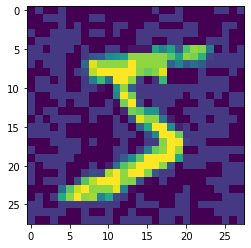

In [23]:
if channels == 1:
    plt.imshow(adversarial.reshape((img_rows, img_cols)))
else:
    plt.imshow(adversarial.reshape((img_rows, img_cols, channels)))
plt.show()

In [24]:
print(labels[model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax()])
print(labels[model.predict(adversarial).argmax()])

five
three


2021-10-15 19:57:52.699009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [25]:
def generate_adversarials(batch_size):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            N = random.randint(0, 100)

            label = y_train[N]
            image = x_train[N]
            
            perturbations = adversarial_pattern(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
            
            
            epsilon = 0.5
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(y_train[N])
        
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        
        yield x, y

In [33]:
adversarials, correct_labels = next(generate_adversarials(12))
for adversarial, correct_label in zip(adversarials, correct_labels):
    print('Prediction:', labels[model.predict(adversarial.reshape((1, img_rows, img_cols, channels))).argmax()], 'Truth:', labels[correct_label.argmax()])

Prediction: nine Truth: one
Prediction: three Truth: seven
Prediction: three Truth: nine
Prediction: four Truth: seven
Prediction: three Truth: three
Prediction: nine Truth: one
Prediction: one Truth: three
Prediction: six Truth: three
Prediction: zero Truth: seven
Prediction: eight Truth: three
Prediction: eight Truth: five
Prediction: three Truth: two


In [27]:
x_adversarial_train, y_adversarial_train = next(generate_adversarials(20000))
x_adversarial_test, y_adversarial_test = next(generate_adversarials(10000))

In [28]:
model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0)

[0.18691717088222504, 0.0]

In [29]:
model.fit(x_adversarial_train, y_adversarial_train,
          batch_size=32,
          epochs=3,
          validation_data=(x_test, y_test))

Epoch 1/10
625/625 [==============================] - 4s 7ms/step - loss: 0.0417 - accuracy: 0.7706 - val_loss: 0.0078 - val_accuracy: 0.9531
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 5.0553e-04 - accuracy: 0.9967 - val_loss: 0.0078 - val_accuracy: 0.9518
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 2.0421e-04 - accuracy: 0.9988 - val_loss: 0.0072 - val_accuracy: 0.9539
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 2.2869e-04 - accuracy: 0.9986 - val_loss: 0.0078 - val_accuracy: 0.9504
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 2.0810e-04 - accuracy: 0.9987 - val_loss: 0.0096 - val_accuracy: 0.9391
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 1.8763e-04 - accuracy: 0.9988 - val_loss: 0.0098 - val_accuracy: 0.9354
Epoch 7/10
625/625 [==============================] - 4s 7ms/step - loss: 1.3402e-04 - accuracy: 0.9992 - val_loss: 0.0128 - val

In [31]:
model.evaluate(x=x_test, y=y_test, verbose=0)

[0.02372768148779869, 0.8488000631332397]